# Import libs

In [1]:
import sys
sys.path.append("../images_with_proper_colors/")
from utils import *
# from my_utils import *
import my_utils 
# print(utils.__file__)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from skimage.color import rgb2gray
from skimage.morphology import skeletonize
from scipy.signal import convolve2d

In [2]:
data_folder = "../images_with_proper_colors/"
data = pd.read_csv(data_folder + "segmentation_modified.csv", sep=";")

In [3]:
images, segmentations, filenames, labels = get_data(data, voting=False, images_path=(data_folder + "images"), labeling=True)

GETTING DATA...


In [4]:
images_voting, segmentations_voting, filenames_voting, labels_voting = get_data(data, voting=True, images_path=(data_folder + "images"), labeling=True)

GETTING DATA...


## Draw mask next to image

Code for drawing image next to mask

In [5]:
def draw_mask_and_image(image,mask):
    width, height = 512, 512
    plt.figure(figsize=(width / 80, height / 80), dpi=80)

    plt.subplot(1, 2, 1)
    plt.imshow(mask)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(image, cmap='gray')
    plt.axis('off')

    plt.subplots_adjust(top=1, bottom=0, right=1, left=0,
                            hspace=0, wspace=0)
    plt.margins(0, 0) 

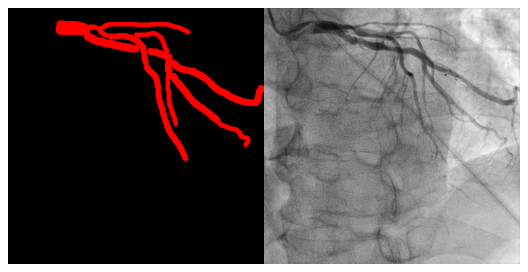

In [357]:
index_binary = index = 12
image_binary = images_voting[index_binary]
image = images[index]
my_mask_binary = get_mask(images_voting[index_binary], segmentations_voting[index_binary], labels_voting[index_binary], name=filenames_voting[index_binary], folder_name='ground_truth', binary=True, ground_truth=True)
clear_output(wait=True)
draw_mask_and_image(image_binary, my_mask_binary)

In [358]:
mask_binary = np.copy(my_mask_binary)
mask_binary = np.round(mask_binary * 255).astype(np.uint8)

# Preprocessing image

(-0.5, 511.5, 511.5, -0.5)

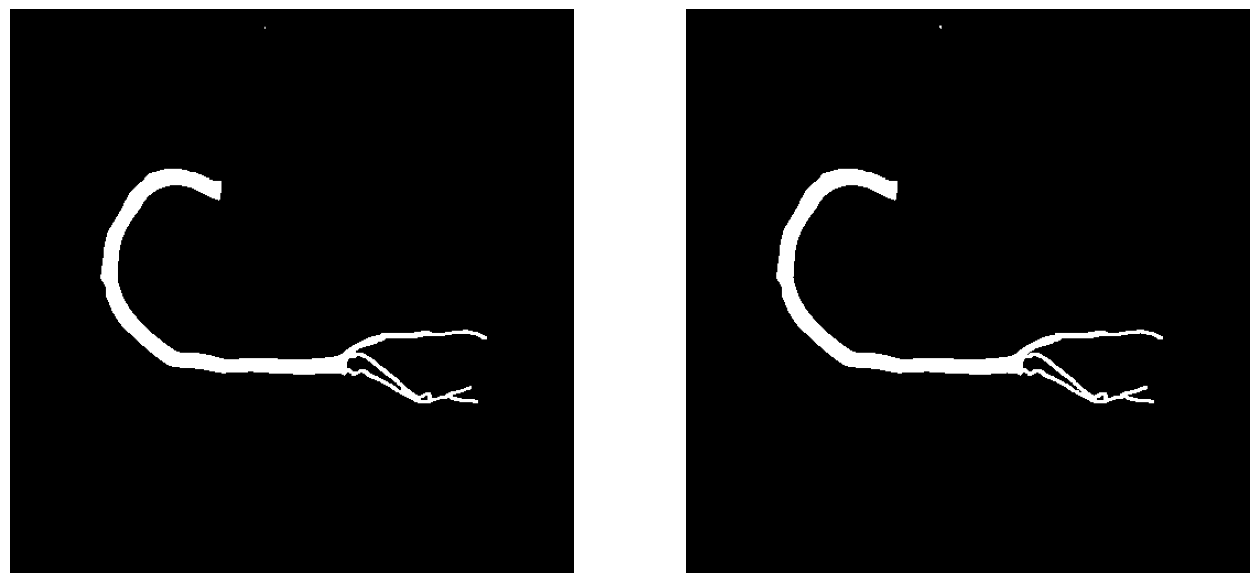

In [748]:
# preprocess
from skan.pre import threshold
import imageio as iio
from skimage import color
from scipy.ndimage import laplace
from matplotlib.lines import Line2D
from skimage.morphology import erosion, disk, dilation

# Define the structuring element
# selem = disk(1.001)  # adjust the radius to control the amount of erosion

def preprocess(mask_binary):
    mask_gray = rgb2gray(mask_binary)

    mask_to_preprocess = mask_gray
    for i in range(2):
        selem = disk(1.001)
        image_dilated = dilation(mask_to_preprocess, selem)
        selem = disk(1.5001)
        mask_to_preprocess = erosion(image_dilated, selem)
    
    return mask_to_preprocess, mask_gray
mask_to_preprocess, mask_gray = preprocess(mask_binary)


plt.figure(figsize=(16, 10))
# Display the result
plt.subplot(1, 2, 1)
# plt.imshow(mask_gray_erosion, cmap='gray')
plt.imshow(mask_to_preprocess, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask_gray, cmap='gray')
plt.axis('off')


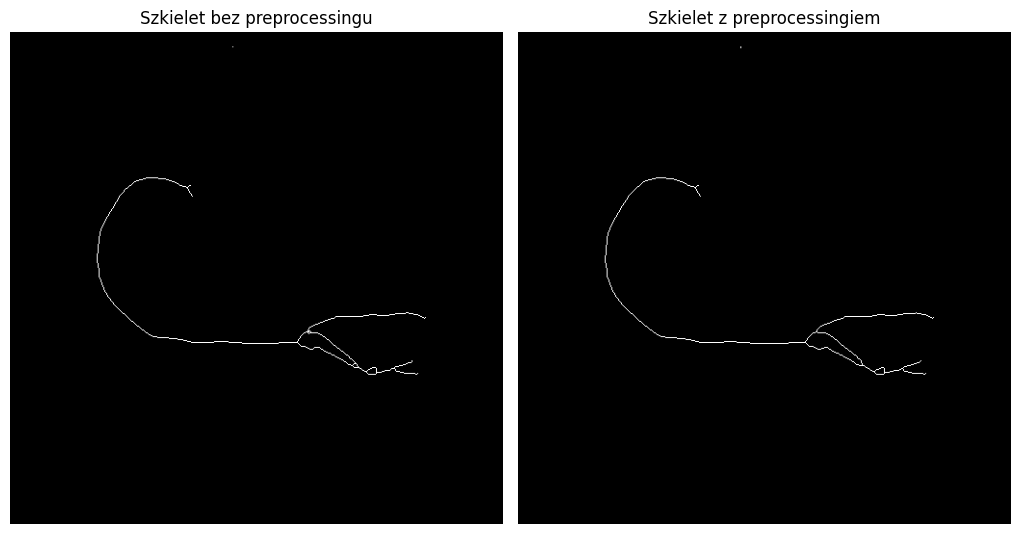

In [749]:
import networkx as nx
from skimage.morphology import skeletonize
from skimage.util import invert
from skimage import img_as_ubyte
from skimage.io import imread
from skan import summarize, csr, Skeleton

def get_skeleton_from_mask(mask):
    # Convert the mask to grayscale
    # grayscale_mask = rgb2gray(mask)
    grayscale_mask = mask

    # Apply a threshold to create a binary mask of the boundaries
    binary_mask = grayscale_mask > 0

    # Apply skeletonization
    skeleton = skeletonize(binary_mask, method='zhang')

    return skeleton

skeleton_binary = get_skeleton_from_mask(mask_to_preprocess)
skeleton_binary_no_preprocessing = get_skeleton_from_mask(mask_gray)
# draw both
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Szkielet bez preprocessingu")
plt.imshow(skeleton_binary_no_preprocessing, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Szkielet z preprocessingiem")
plt.imshow(skeleton_binary, cmap='gray')
plt.axis('off')

# Adjust layout to remove white space
plt.tight_layout()
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

plt.savefig('for-thesis/skeletons.png', bbox_inches='tight')
clear_output(wait=True)


In [808]:
def find_keypoints_on_graph(skeleton):
    distance_threshold = 6

    # Create a graph from the skeleton
    pixel_graph, coordinates = csr.skeleton_to_csgraph(skeleton)

    G = nx.from_scipy_sparse_array(pixel_graph)

    # draw graph
    endpoints = [node for node, degree in G.degree() if degree == 1]
    branchpoints = [node for node, degree in G.degree() if degree == 3]
    # sort branchpoints by distance from 0,0 point so it would be math.sqrt(x^2 + y^2)
    branchpoints = sorted(branchpoints, key=lambda x: coordinates[0][x] ** 2 + coordinates[1][x] ** 2)
    # degree > 3 for crossroads
    crossroads = [node for node, degree in G.degree() if degree > 3]  # Not sure if there will be ever any ?

    # Filter out branchpoints that are close to endpoints
    filtered_branchpoints = []
    filtered_out = []
    for branchpoint in branchpoints:
        try:
            min_distance = min(
                nx.shortest_path_length(G, branchpoint, endpoint)
                for endpoint in endpoints
                if nx.has_path(G, branchpoint, endpoint)
            )
            if min_distance > distance_threshold:
                filtered_branchpoints.append(branchpoint)
            else:
                filtered_out.append(branchpoint)
        except ValueError:
            print(f"No path found from branchpoint {branchpoint} to any endpoint.")

    def bfs_paths(graph, start, goal, branchpoint):
        queue = [(start, [start], 0)]
        visited = set()
        visited.add(branchpoint)
        while queue:
            (vertex, path, depth) = queue.pop(0)
            visited.add(vertex)
            for next in graph[vertex]:
                if next not in visited:
                    if next == goal:
                        yield path + [next]
                    else:
                        # for consideration if i should check next in filtered_out #TODO
                        # new_depth = depth + 1 if next in filtered_branchpoints or next in filtered_out else depth
                        new_depth = (
                            depth + 1 if next in filtered_branchpoints else depth
                        )  # (this is for not checking filtered_out)
                        if new_depth < 2:
                            queue.append((next, path + [next], new_depth))

    # define bfs that will check for that one neighbor and find nearest branchpoint
    def bfs_find_in_distance(graph, start, max_distance, filtered_branchpoints):
        queue = [(start, [start], 0)]
        visited = set()
        while queue:
            (vertex, path, distance) = queue.pop(0)
            visited.add(vertex)
            for next in graph[vertex]:
                if next not in visited:
                    new_distance = distance + 1
                    if next in filtered_branchpoints:
                        if coordinates[0][start] - coordinates[0][next] < 40:
                            return next, False
                        continue 
                    elif next in endpoints:
                        return next, True
                    
                    if new_distance < max_distance:
                        queue.append((next, path + [next], new_distance))
                    else:
                        return None, False

    crossings = set()
    crossings_connected = []
    # filtered_branchpoints = [branchpoint for branchpoint in filtered_branchpoints if branchpoint not in crossings] doubt if this is needed

    for i, branchpoint1 in enumerate(filtered_branchpoints):
        for branchpoint2 in filtered_branchpoints[i + 1 :]:
            paths = []
            # paths = list(bfs_paths(G, branchpoint1, branchpoint2))
            for neighbor in G.neighbors(branchpoint1):
                new_paths = list(bfs_paths(G, neighbor, branchpoint2, branchpoint1))
                paths.extend(
                    new_path
                    for new_path in new_paths
                    if not any(
                        set(new_path[1:-1]).intersection(set(existing_path[1:-1]))
                        for existing_path in paths
                    )
                )
            if len(paths) > 1:
                crossings.add(branchpoint2)

    max_distance = 100
    for crossing in crossings.copy():
        nearest_branchpoint, is_filtered_out = bfs_find_in_distance(G, crossing, max_distance, filtered_branchpoints)
        if nearest_branchpoint is not None and not is_filtered_out:
            crossings_connected.append((crossing, nearest_branchpoint))
            crossings.remove(crossing)
        elif nearest_branchpoint is None:
            crossings.remove(crossing)

    crossings_connected_copy = crossings_connected.copy()
    for i, (cross_begin1, cross_end1) in enumerate(crossings_connected_copy):
        for cross_begin2, cross_end2 in crossings_connected_copy[i + 1:]:
            if cross_begin1 == cross_begin2 or cross_end1 == cross_end2 or cross_begin1 == cross_end2 or cross_end1 == cross_begin2:
                path1 = nx.shortest_path(G, cross_begin1, cross_end1)
                path2 = nx.shortest_path(G, cross_begin2, cross_end2)
                if len(path1) < len(path2):
                    if (cross_begin2, cross_end2) in crossings_connected:
                        crossings_connected.remove((cross_begin2, cross_end2))
                else:
                    if (cross_begin1, cross_end1) in crossings_connected:
                        crossings_connected.remove((cross_begin1, cross_end1))

    filtered_branchpoints = [
        branchpoint
        for branchpoint in filtered_branchpoints
        if branchpoint not in crossings
    ]
    filtered_branchpoints = [
        branchpoint
        for branchpoint in filtered_branchpoints
        if branchpoint not in [branchpoint for branchpoint, _ in crossings_connected]
    ]
    filtered_branchpoints = [
        branchpoint
        for branchpoint in filtered_branchpoints
        if branchpoint not in [branchpoint for _, branchpoint in crossings_connected]
    ]
    
    return coordinates, endpoints, crossings, filtered_branchpoints, filtered_out, crossings_connected


In [809]:
def draw_everything_else(image_binary, skeleton, coordinates, endpoints, crossings, filtered_branchpoints, filtered_out, crossings_connected):
    fig1 = plt.figure(figsize=(10, 5))
    gs1 = fig1.add_gridspec(1, 2)

    # First subplot
    ax1 = fig1.add_subplot(gs1[0, 0])
    ax1.imshow(image_binary, cmap='gray')
    ax1.axis('off')
    ax1.set_title('Obraz DICOM')

    # Second subplot
    ax2 = fig1.add_subplot(gs1[0, 1])

    ax2.imshow(skeleton)
    ax2.axis('off')
    ax2.set_title('Szkielet')

    plt.tight_layout()
    plt.show()

    # Second figure for the third image
    fig2 = plt.figure(figsize=(10, 10))
    ax3 = fig2.add_subplot(111)
    ax3.imshow(skeleton, cmap='gray')
    ax3.axis('off')
    ax3.set_title('Szkielet z punktami')

    size = 50
    for endpoint in endpoints:
        ax3.scatter(coordinates[1][endpoint], coordinates[0][endpoint], c='y', s=size)

    # for branchpoint in branchpoints:
    #     plt.scatter(coordinates[1][branchpoint], coordinates[0][branchpoint], c='b', s=10)

    # for branchpoint in crossroads:
    #     plt.scatter(coordinates[1][branchpoint], coordinates[0][branchpoint], c='g', s=10)
    
    for branchpoint in filtered_branchpoints:
        ax3.scatter(coordinates[1][branchpoint], coordinates[0][branchpoint], c='b', s=size)

    for branchpoint in filtered_out:
        ax3.scatter(coordinates[1][branchpoint], coordinates[0][branchpoint], c='g', s=size)
    
    for branchpoint in crossings:
        # candidates for crossroads
        ax3.scatter(coordinates[1][branchpoint], coordinates[0][branchpoint], c='r', s=size)
    
    for branchpoint1, branchpoint2 in crossings_connected:
        ax3.scatter(
            coordinates[1][branchpoint1],
            coordinates[0][branchpoint1],
            c="r",
            s=size,
            zorder=5,
        )
        ax3.scatter(
            coordinates[1][branchpoint2],
            coordinates[0][branchpoint2],
            c="r",
            s=size,
            zorder=5,
        )

        ax3.plot(
            [coordinates[1][branchpoint1], coordinates[1][branchpoint2]],
            [coordinates[0][branchpoint1], coordinates[0][branchpoint2]],
            c="orange",
            linewidth=4,
        )

    # legend blue - bifurcation, red potential crossing, green - filtered out
    legend_elements = [Line2D([0], [0], marker='o', color='w', label='Bifurcation', markerfacecolor='b', markersize=15),
                   Line2D([0], [0], marker='o', color='w', label='Filtered Out', markerfacecolor='g', markersize=15),
                   Line2D([0], [0], marker='o', color='w', label='Potential Crossing', markerfacecolor='r', markersize=15),
                   Line2D([0], [0], color="orange", linewidth=4, label="Connected Crossings")]
    ax3.legend(handles=legend_elements, loc='upper right', prop={'size': 15})

    # plt.subplots_adjust(wspace=0.05, hspace=0.10)
    plt.tight_layout()
    plt.show()
  

In [810]:
def keypoints_algorithm(image_binary, skeleton_binary):
    coordinates, endpoints, crossings, filtered_branchpoints, filtered_out, crossings_connected = find_keypoints_on_graph(skeleton_binary)
    draw_everything_else(image_binary, skeleton_binary, coordinates, endpoints, crossings, filtered_branchpoints, filtered_out, crossings_connected)

[0. 1.]
[  0. 255.]
(512, 512)


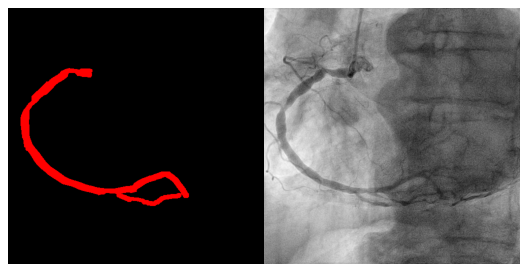

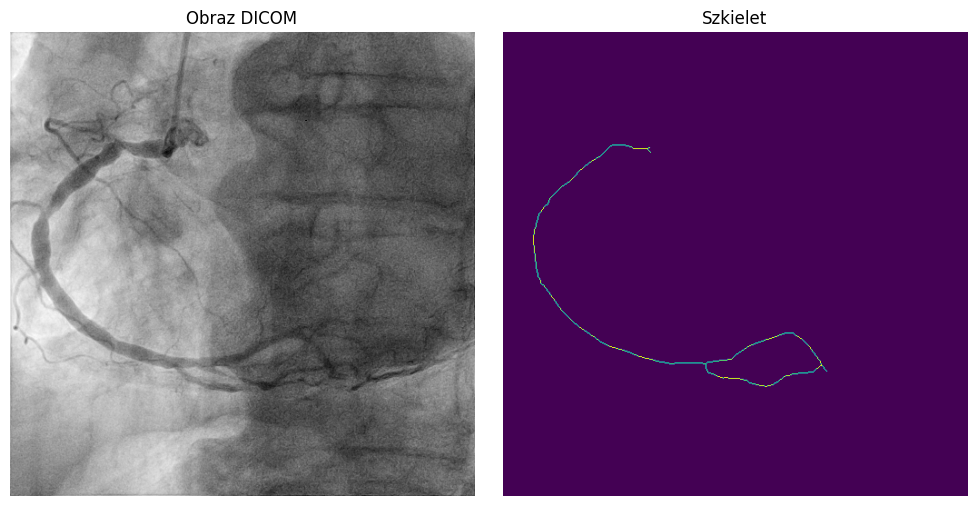

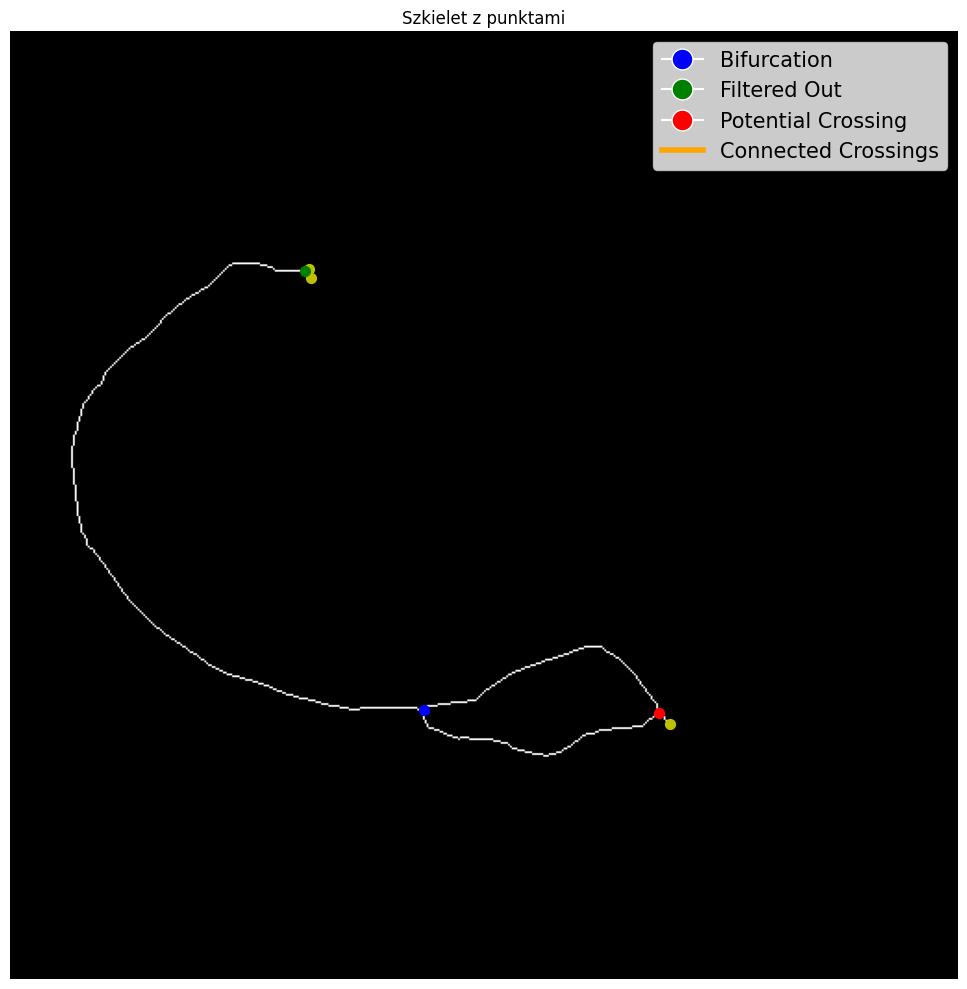

In [838]:
index_binary = index = 9
image_binary = images_voting[index_binary]
image = images[index]
mask_binary = get_mask(images_voting[index_binary], segmentations_voting[index_binary], labels_voting[index_binary], name=filenames_voting[index_binary], folder_name='ground_truth', binary=True, ground_truth=True)
draw_mask_and_image(image_binary, mask_binary)

mask_to_preprocess, _ = preprocess(mask_binary)
skeleton_binary = get_skeleton_from_mask(mask_to_preprocess)
keypoints_algorithm(image_binary, skeleton_binary)